# Clasificador de Desechos 🗑️

🧑🏽‍💻 **Said Ortigoza Trujillo, A01707430**

### Conexión con Google Drive y visualización del directorio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path en Drive de la carpeta del dataset
%cd "/content/drive/MyDrive/TEC/Semestre 8/Waste Classification"
!ls

Mounted at /content/drive
/content/drive/MyDrive/TEC/Semestre 8/Waste Classification
Dataset  ExternalImage	Test  Train  Validation


### Importar las librerías necesarias

**pandas (pd):** Ofrece estructuras de datos y funciones para trabajar con datos tabulares y series temporales de manera eficiente.

**numpy (np):** Proporciona soporte para matrices multidimensionales y una amplia gama de funciones matemáticas para operar con estas matrices de manera eficiente.

**matplotlib.pyplot (plt):** Para crear gráficos, diagramas y trazados para explorar y comunicar datos.

**os:** Se utiliza para manipular archivos, directorios y rutas de archivos.

**shutil:** Se utiliza para copiar, mover y eliminar archivos y directorios.

**random:** Se utiliza para generar secuencias de números aleatorios y para mezclar aleatoriamente elementos de una lista.

**tensorflow.keras.models.Sequential:** Proporciona una forma simple y lineal de crear modelos de redes neuronales capa por capa.

**tensorflow.keras.layers.Conv2D:** Se utiliza para agregar capas convolucionales a los modelos de redes neuronales.

**tensorflow.keras.layers.MaxPooling2D:** Se utiliza para agregar capas de agrupamiento máximo, que reducen las dimensiones espaciales de las imágenes, manteniendo las características más importantes.

**tensorflow.keras.layers.Flatten:** Convierte una matriz 2D en un vector 1D, facilitando la transición entre las capas convolucionales y las densas.

**tensorflow.keras.layers.Dense:** Se utiliza para agregar capas densamente conectadas (totalmente conectadas) a los modelos de redes neuronales.

**tensorflow.keras.layers.Dropout:** Se utiliza para agregar capas de dropout, que ayudan a prevenir el sobreajuste durante el entrenamiento.

**tensorflow.keras.layers.BatchNormalization:** Se utiliza para agregar capas de normalización por lotes, que ayudan a acelerar el entrenamiento y mejorar la estabilidad del modelo.

**tensorflow.keras.preprocessing.image.ImageDataGenerator:** Se utiliza para cargar y preprocesar imágenes para su uso en modelos de redes neuronales.

**tensorflow.keras.optimizers:** Proporciona diferentes optimizadores para ajustar los parámetros del modelo durante el entrenamiento.

**tensorflow.keras.models:** Proporciona funciones y clases para la creación y manipulación de modelos de redes neuronales.

**tensorflow.keras.layers:** Proporciona diferentes tipos de capas para construir modelos de redes neuronales.

**glob:** Se utiliza para buscar y listar archivos en un directorio.

**PIL.Image:** Se utiliza para abrir, manipular y guardar imágenes en varios formatos de archivo.

**oogle.colab.files:** Proporciona herramientas para subir y descargar archivos desde Google Colab.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

from glob import glob
from PIL import Image

from google.colab import files

### Directorios del dataset inicial, entrenamiento, prueba y validación

In [ ]:
# Rutas de las carpetas
base_dir = 'Dataset'
train_dir = 'Train'
test_dir = 'Test'
val_dir = 'Validation'

### Creación de los subdirectorios de cada conjunto, a partir del directorio base

In [ ]:
classes = [os.path.basename(d) for d in glob(os.path.join(base_dir, '*')) if os.path.isdir(d)]
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

### Configuración de las proporciones del split

In [ ]:
train_split = 0.80
test_split = 0.10
val_split = 0.10

### División y reubicación de los archivos del directorio base en entrenamiento, prueba y validación

In [ ]:
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = glob(os.path.join(cls_path, '*'))

    # Mezclar las imágenes
    random.shuffle(images)

    # Calcular los índices para división
    train_size = int(len(images) * train_split)
    val_size = int(len(images) * val_split)
    test_size = len(images) - train_size - val_size

    # Dividir las imágenes
    train_images = images[:train_size]
    val_images = images[train_size:train_size+val_size]
    test_images = images[train_size+val_size:]

    # Mover las imágenes a las carpetas correspondientes
    for img in train_images:
        shutil.move(img, os.path.join(train_dir, cls))
    for img in val_images:
        shutil.move(img, os.path.join(val_dir, cls))
    for img in test_images:
        shutil.move(img, os.path.join(test_dir, cls))

### Configuración del generador de datos

In [ ]:
# Generador de datos de entrenamiento
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.05,
    horizontal_flip = True,
    fill_mode='reflect'
)

# Generador de datos de validación
val_datagen = ImageDataGenerator(rescale = 1/255)

# Generador de datos de prueba
test_datagen = ImageDataGenerator(rescale=1/255)

### Cargar los tres conjuntos

In [ ]:
# Cargar el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode ='categorical'
)

# Cargar el conjunto de validación
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode ='categorical'
)

# Cargar el conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode ='categorical'
)

labels = train_generator.class_indices

# Invertir el diccionario para que los índices sean las claves y las etiquetas sean los valores
labels = {valor: clave for clave, valor in labels.items()}

# Imprimir las etiquetas de las clases
print("\nEtiquetas:")
for index, name in labels.items():
    print(f"{index}: {name}")

Found 1802 images belonging to 5 classes.
Found 224 images belonging to 5 classes.
Found 229 images belonging to 5 classes.

Etiquetas:
0: Cardboard
1: Food Organics
2: Glass
3: Metal
4: Plastic


### Visualización de imágenes generadas con data augmentation

<Figure size 640x480 with 0 Axes>

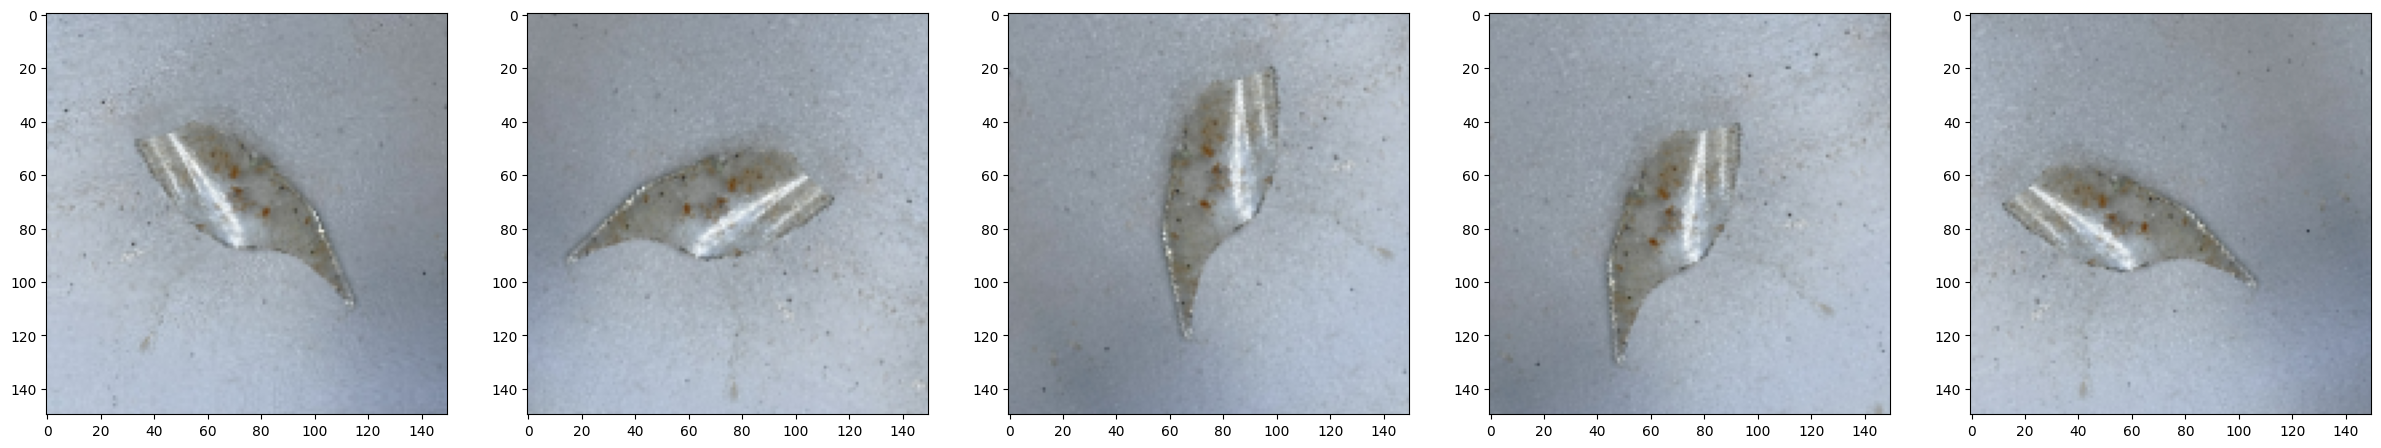

In [ ]:
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5):
  axarr[i].imshow(train_generator[0][0][0])

### Definición del modelo

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(32, activation='relu'),

    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)        0

### Entrenamiento del modelo

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
57/57 [==============================] - 745s 13s/step - loss: 1.5780 - accuracy: 0.2630 - val_loss: 1.4466 - val_accuracy: 0.3973
Epoch 2/30
57/57 [==============================] - 23s 408ms/step - loss: 1.3769 - accuracy: 0.4240 - val_loss: 1.4147 - val_accuracy: 0.4420
Epoch 3/30
57/57 [==============================] - 24s 429ms/step - loss: 1.2595 - accuracy: 0.5017 - val_loss: 1.3122 - val_accuracy: 0.4777
Epoch 4/30
57/57 [==============================] - 24s 424ms/step - loss: 1.1960 - accuracy: 0.5083 - val_loss: 1.2827 - val_accuracy: 0.4777
Epoch 5/30
57/57 [==============================] - 24s 422ms/step - loss: 1.1387 - accuracy: 0.5400 - val_loss: 1.2313 - val_accuracy: 0.4911
Epoch 6/30
57/57 [==============================] - 26s 453ms/step - loss: 1.0793 - accuracy: 0.5749 - val_loss: 1.0428 - val_accuracy: 0.5848
Epoch 7/30
57/57 [==============================] - 24s 415ms/step - loss: 1.0405 - accuracy: 0.5977 - val_loss: 1.0875 - val_accuracy: 0.5714


### Gráfico de métricas para los conjuntos train y validation

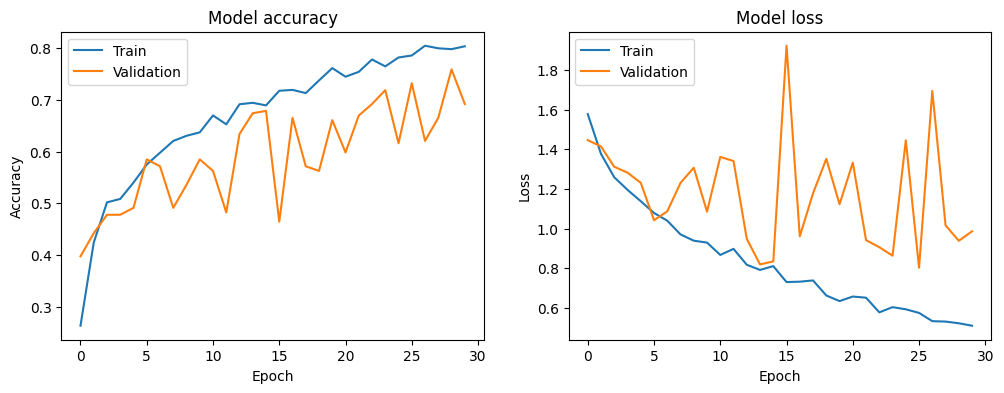

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Predicciones con el modelo actual

1/1 [==============================] - 0s 23ms/step


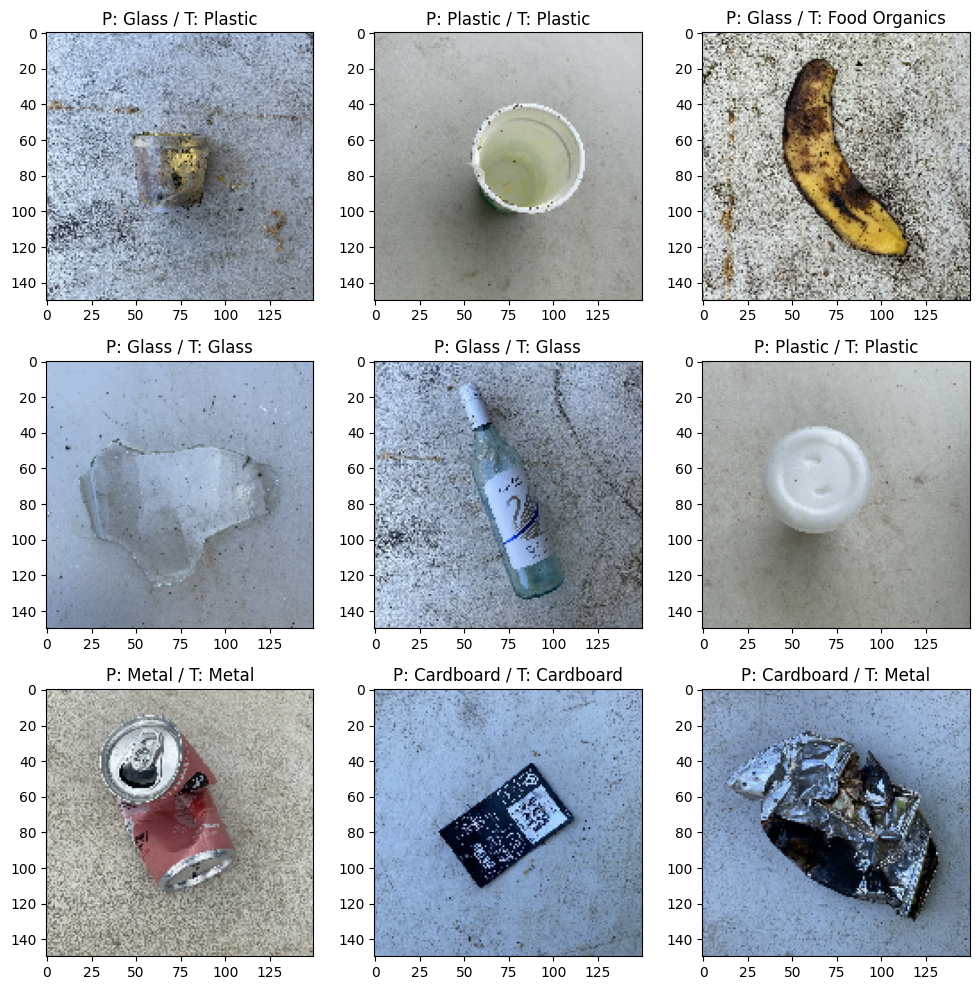

In [ ]:
test_x, test_y = test_generator.__getitem__(1)

predictions = model.predict(test_x)

plt.figure(figsize=(10, 10))

# Iterar sobre las primeras 9 imágenes y predicciones
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title('P: %s / T: %s' % (labels[np.argmax(predictions[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.tight_layout()
plt.show()

### Matriz de confusión

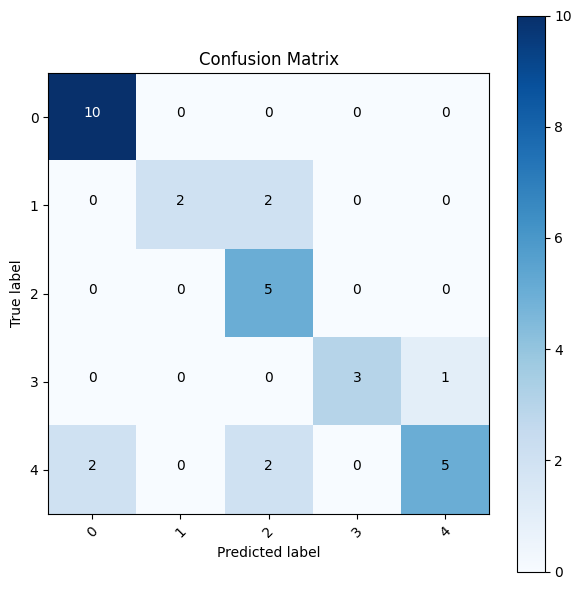

In [ ]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = confusion_matrix.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(confusion_matrix[i][j], 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i][j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calcular la matriz de confusión
confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)
for pred, true_label in zip(predictions, test_y):
    pred_index = np.argmax(pred)
    true_index = np.argmax(true_label)
    confusion_matrix[true_index][pred_index] += 1

plot_confusion_matrix(confusion_matrix, labels)
plt.show()

### Evaluación del modelo con el conjunto de prueba y gráfico de métricas de los 3 conjuntos

8/8 [==============================] - 91s 13s/step - loss: 0.8947 - accuracy: 0.7162
Test Accuracy: 0.72


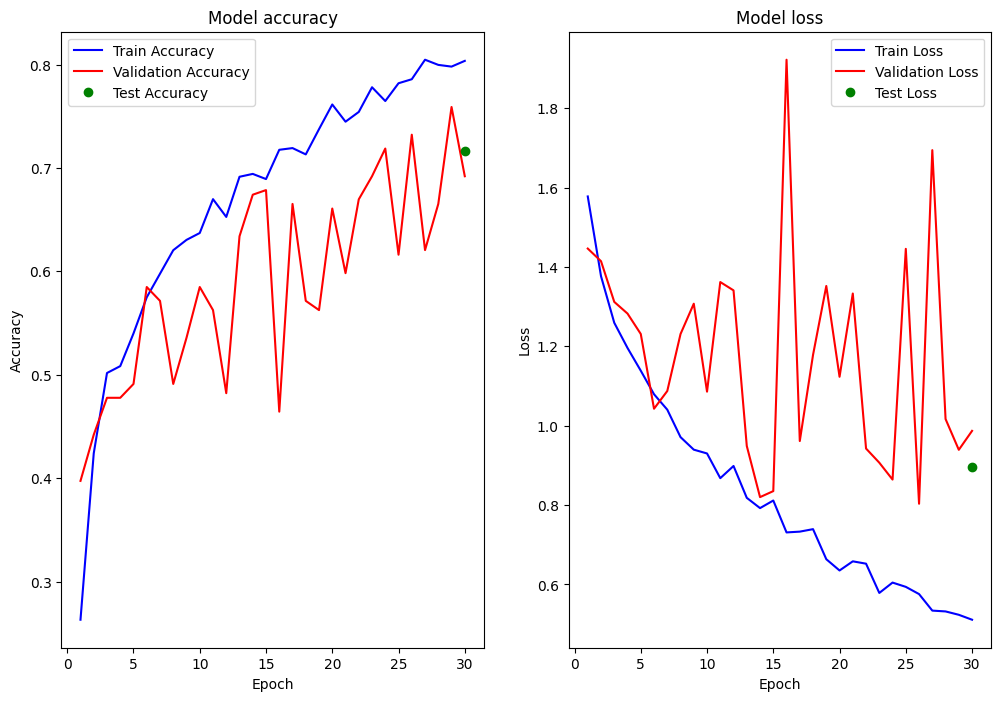

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Graficar la precisión y la pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear una figura para las gráficas
plt.figure(figsize=(12, 8))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, 'b-', label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, 'r-', label='Validation Accuracy')
plt.plot(len(acc), test_accuracy, 'go', label='Test Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, 'b-', label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r-', label='Validation Loss')
plt.plot(len(loss), test_loss, 'go', label='Test Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Guardar el modelo

In [ ]:
model.save("/content/drive/MyDrive/TEC/Semestre 8/modelo_WasteClassification_FinalV.h5")
model.save("/content/drive/MyDrive/TEC/Semestre 8/modelo_WasteClassification_FinalV.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Cargar el modelo

In [ ]:
model_path = '/content/drive/MyDrive/TEC/Semestre 8/modelo_WasteClassification_FinalV.h5'
model = load_model(model_path)

### Predicciones con el modelo a partir de imágenes externas

1/1 [==============================] - 0s 20ms/step


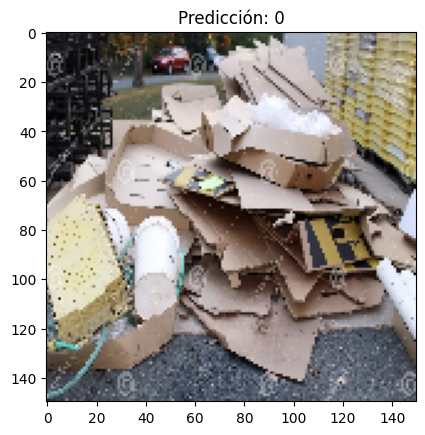

1/1 [==============================] - 0s 19ms/step


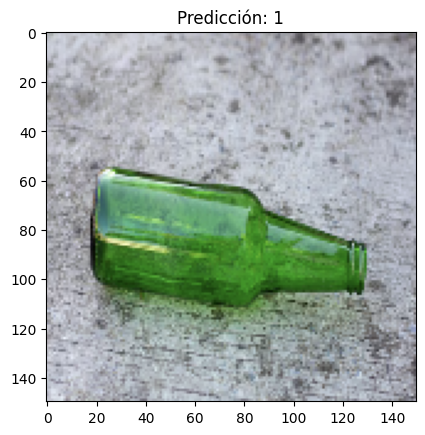

1/1 [==============================] - 0s 19ms/step


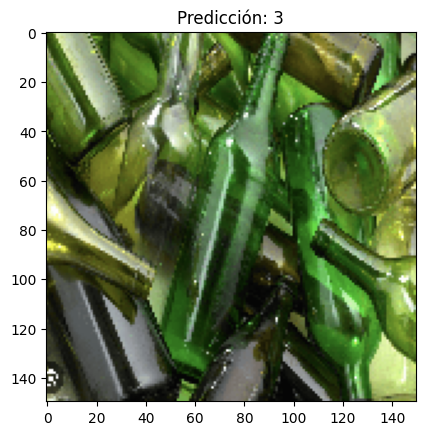

1/1 [==============================] - 0s 19ms/step


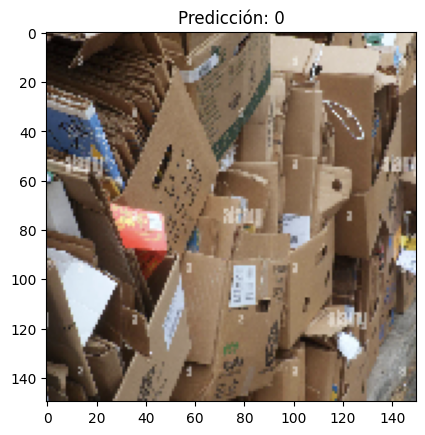

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directorio de las imágenes externas
external_image_dir = '/content/drive/MyDrive/TEC/Semestre 8/Waste Classification/ExternalImage/test_images'

# Obtener la lista de archivos de imagen en el directorio
image_files = [os.path.join(external_image_dir, fname) for fname in os.listdir(external_image_dir) if fname.endswith(('jpg', 'png', 'jpeg'))]

# Preprocesar y predecir cada imagen
for image_file in image_files:
    # Cargar la imagen
    # Tamaño esperado del modelo
    img = load_img(image_file, target_size=(150, 150))
    # Escalar la imagen
    img_array = img_to_array(img) / 255.0
    # Añadir una dimensión para el batch
    img_array = np.expand_dims(img_array, axis=0)

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Mostrar la imagen y la predicción
    plt.imshow(img)
    plt.title(f'Predicción: {predicted_class}')
    plt.show()